In [1]:
import Pkg
Pkg.activate(@__DIR__)
# Pkg.upgrade_manifest()
# Pkg.update()
Pkg.resolve()
Pkg.instantiate()

import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
import MuJoCo
using LinearAlgebra
import Plots
using Random
using JLD2
using Test
using StaticArrays
using Printf
using Distributions
using MathOptInterface

  Activating project at `c:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories`
  No Changes to `C:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories\Project.toml`
  No Changes to `C:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories\Manifest.toml`


In [2]:
Threads.nthreads()
using MuJoCo
install_visualiser()

┌ Error: curl_easy_setopt: 4
└ @ Downloads.Curl C:\Users\AiPEX-WS4\.julia\juliaup\julia-1.10.4+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Downloads\src\Curl\utils.jl:50
   Resolving package versions...
  No Changes to `C:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories\Project.toml`
  No Changes to `C:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories\Manifest.toml`


### Load Model and Info

In [3]:
# model = load_model("../mujoco_menagerie/shadow_hand/scene_right_piano_hand.xml")
println(pwd())
model = load_model("models/scene_right_piano_hand.xml")
# model = load_model("scene_right_piano_hand.xml")
data = init_data(model)

nx = 2*model.nv
nu = model.nu

println("States: ", nx)
println("Controls: ", nu)
ϵ = 1e-6

init_visualiser()
function random_controller!(m::Model, d::Data)
    nu = m.nu
    d.ctrl .= 2*rand(nu) .- 1
    return nothing
end

println("Initial joint positions:", data.qpos)
println("Initial joint velocities:", data.qvel)

mj_resetData(model, data)

## Random Controller
# for t in 1:100
#     random_controller!(model, data)
#     step!(model, data)
# end
# println("New joint positions:", data.qpos)

# visualise!(model, data, controller=random_controller!)



c:\Users\AiPEX-WS4\Documents\ocrl-piano\single_finger_free_trajectories
States: 54
Controls: 23
Initial joint positions:[0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]
Initial joint velocities:[0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]


### Dynamics

In [23]:
function wrapped_mj_step(model, data, x, uk)
    # given the current model and data. set the state and control to the model and perform a forward step
    if typeof(x) == Vector{Float64}
        # set control 
        # data.ctrl[7:9] = uk
        data.ctrl .= uk
        # set state
        data.qpos .= x[1:model.nq]
        data.qvel .= x[(model.nq + 1):end]
        # data.qpos[94:96] = x[1:3]
        # data.qvel[94:96] = x[4:6]
    else
        # if using diff types, we need to convert the dual numbers to floats
        converted_uk = ForwardDiff.value.(uk)
        converted_x = ForwardDiff.value.(x)
        # set control
        data.ctrl[:] .= converted_uk

        # set state
        data.qpos .= converted_x[1:model.nq]
        data.qvel .= converted_x[(model.nq + 1):end]
    end
    
    # take discrete dynamics step 
    step!(model, data) 

    # return updated state k + 1
    xkp1 = zeros(model.nq + model.nv) 
    xkp1 .= get_physics_state(model, data)
    # finger_coordinates = data.geom_xpos[finger_geom_indices,:]
    
    return xkp1
end

function robohand_cost(params::NamedTuple, Z::Vector)::Real
    # TODO: implement cost function
    idx, N, xg = params.idx, params.N, params.xg
    model = params.model
    data = params.data
    Q, R, Qf = params.Q, params.R, params.Qf

    # stage cost
    cost = 0.0
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]

        # @show xi-xg
        # cost += 0.5*(xi[94:96]-xg[94:96])'*Q*(xi[94:96]-xg[94:96])+0.5*ui'*R*ui
        cost += 0.5*(xi-xg)'*Q*(xi-xg)+0.5*ui'*R*ui
    end

    # terminal cost 
    xf = Z[idx.x[N]]
    # cost += 0.5*(xf[94:96]-xg[94:96])'*Qf*(xf[94:96]-xg[94:96])
    cost += 0.5*(xf-xg)'*Qf*(xf-xg)

    return cost
end

function robohand_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    model = params.model
    data = params.data
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # data.qpos[94:96] = xi[1:3]
        # data.qvel[94:96] = xi[4:6]

        xip1_mujoco = wrapped_mj_step(model, data, xi, ui)

        c[idx.c[i]] = xip1_mujoco - xip1
    end
    # println(typeof(c))
    return c 
end


function robohand_equality_constraints(params::NamedTuple, Z::Vector)::Vector
    # TODO: implement equality constraints
    # return zeros(eltype(Z), 0)
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    model = params.model
    data = params.data

    con_1 = Z[idx.x[1]] - xic
    con_2 = Z[idx.x[N]] - xg

    return [con_1; con_2; robohand_dynamics_constraints(params, Z)]
    # return [con_1; con_2]
end

function robohand_inequality_constraints(params::NamedTuple, Z::Vector)::Vector
    # TODO: implement inequality constraints
    # println(Z)
    return zeros(eltype(Z), 0)
    # return inequality_constraints
end

function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end


create_idx (generic function with 1 method)

### DIRCOL

In [5]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

In [6]:
@show model.nq
@show model.jnt_range
@show model.jnt_range[:,1]

@show vcat(model.jnt_range[:,1], Inf*ones(model.nv))

@show model.actuator_ctrlrange

model.nq = 27
model.jnt_range = [-0.2 0.2; -0.5 0.5; -0.2 0.2; -0.523599 0.174533; -0.698132 0.488692; -0.349066 0.349066; -0.261799 1.5708; 0.0 1.5708; 0.0 1.5708; -0.349066 0.349066; -0.261799 1.5708; 0.0 1.5708; 0.0 1.5708; -0.349066 0.349066; -0.261799 1.5708; 0.0 1.5708; 0.0 1.5708; 0.0 0.785398; -0.349066 0.349066; -0.261799 1.5708; 0.0 1.5708; 0.0 1.5708; -1.0472 1.0472; 0.0 1.22173; -0.20944 0.20944; -0.698132 0.698132; -0.261799 1.5708]
model.jnt_range[:, 1] = [-0.2, -0.5, -0.2, -0.523599, -0.698132, -0.349066, -0.261799, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, -1.0472, 0.0, -0.20944, -0.698132, -0.261799]
vcat(model.jnt_range[:, 1], Inf * ones(model.nv)) = [-0.2, -0.5, -0.2, -0.523599, -0.698132, -0.349066, -0.261799, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, 0.0, -0.349066, -0.261799, 0.0, 0.0, -1.0472, 0.0, -0.20944, -0.698132, -0.261799, Inf, Inf, Inf, Inf, Inf, Inf, Inf,

23×2 transpose(::UnsafeArrays.UnsafeArray{Float64, 2}) with eltype Float64:
 -1.0       1.0
 -1.0       1.0
 -1.0       1.0
 -0.523599  0.174533
 -0.698132  0.488692
 -1.0472    1.0472
  0.0       1.22173
 -0.20944   0.20944
 -0.698132  0.698132
 -0.261799  1.5708
  ⋮         
 -0.261799  1.5708
  0.0       3.1415
 -0.349066  0.349066
 -0.261799  1.5708
  0.0       3.1415
  0.0       0.785398
 -0.349066  0.349066
 -0.261799  1.5708
  0.0       3.1415

Initial state: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Goal state: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


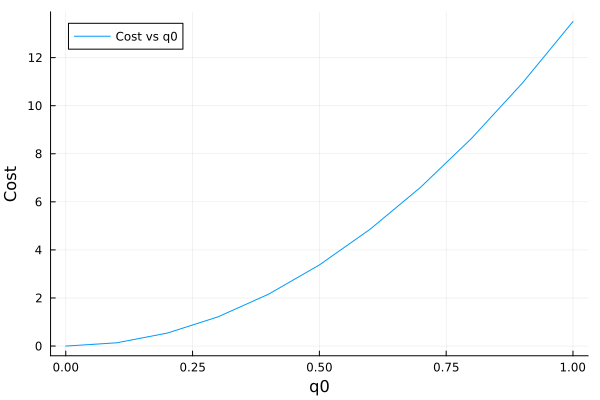

In [21]:
model = load_model("models/scene_right_piano_hand.xml")
data = init_data(model)

# reset the model and data
reset!(model, data)

nx = 2*model.nv
nu = model.nu

# initiate time and time steps
dt = model.opt.timestep
tf = 0.1
t_vec = 0:dt:tf
N = length(t_vec)

# LQR cost
Q = diagm(ones(model.nq + model.nv))
R = 0.1*diagm(ones(model.nu))
Qf = Q

# initial and goal states
xic = vec(vcat(copy(data.qpos), copy(data.qvel)))
println("Initial state: ", xic)

# xg = vec(vcat(copy(data.qpos), copy(data.qvel)))
xg = vec(vcat(copy(data.qpos), copy(data.qvel)))
# xg[1] = deg2rad(2)
println("Goal state: ", xg)

# indexing 
idx = create_idx(model.nq + model.nv, model.nu, N)
idx = create_idx(nx, nu, N)
params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, model=model, data=data)

z0 = zeros(idx.nz)
q0_array = 0:0.1:1
costs = zeros(length(q0_array))
for i in eachindex(q0_array)
    z0[1:model.nq] .= q0_array[i]
    costs[i] = robohand_cost(params, z0)
end
using Plots
plot(q0_array, costs, label="Cost vs q0", xlabel="q0", ylabel="Cost")

In [24]:
function solve_hand_ddp(;verbose=true)
    # instantiate model and data
    model = load_model("models/scene_right_piano_hand.xml")
    data = init_data(model)

    # reset the model and data
    reset!(model, data)

    nx = 2*model.nv
    nu = model.nu

    # initiate time and time steps
    dt = model.opt.timestep
    tf = 0.02
    t_vec = 0:dt:tf
    N = length(t_vec)

    # LQR cost
    Q = diagm(ones(model.nq + model.nv))
    R = 0.1*diagm(ones(model.nu))
    Qf = Q

    # initial and goal states
    xic = vec(vcat(copy(data.qpos), copy(data.qvel)))
    println("Initial state: ", xic)

    # xg = vec(vcat(copy(data.qpos), copy(data.qvel)))
    xg = vec(vcat(copy(data.qpos), copy(data.qvel)))
    # xg[1] = deg2rad(2)
    println("Goal state: ", xg)

    # indexing 
    idx = create_idx(model.nq + model.nv, model.nu, N)
    idx = create_idx(nx, nu, N)
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, model=model, data=data)


    # primal bounds
    # x_l = vcat(model.jnt_range[:,1], -Inf*ones(model.nv), model.actuator_ctrlrange[:,1]) # combine joint pos, vel, and control limits
    # x_u = vcat(model.jnt_range[:,2], Inf*ones(model.nv), model.actuator_ctrlrange[:,2])
    x_l = zeros(idx.nz)
    x_u = zeros(idx.nz)
    for i = 1:N
        # x_l[idx.x[i]] = vcat(model.jnt_range[:,1], -Inf*ones(model.nv))
        # x_u[idx.x[i]] = vcat(model.jnt_range[:,2], Inf*ones(model.nv))
        x_l[idx.x[i]] = vcat(model.jnt_range[:,1], -deg2rad(10)*ones(model.nv))
        x_u[idx.x[i]] = vcat(model.jnt_range[:,2], deg2rad(10)*ones(model.nv))



        if i < N
            x_l[idx.u[i]] = model.actuator_ctrlrange[:,1]
            x_u[idx.u[i]] = model.actuator_ctrlrange[:,2]
        end
    end


    # @show size(xic)
    # @show size(x_l)
    # @show size(x_u)

    # @show idx.x
    # @show idx.u
    # @show idx.nz
    # @show size(ones(idx.nz))

    # inequality constraints
    # c_l = -1 * Inf * ones(3*(idx.N-1))
    # c_u = Inf * ones(3*(idx.N-1))
    c_l = zeros(0)
    c_u = zeros(0)

    # initial guess 
    # z0 = 0.001*randn(idx.nz)
    # z0[idx.x[1]] = xic
    z0 = zeros(idx.nz)

    # diff type
    # diff_type = :auto 
    diff_type = :finite
    
    
    Z = fmincon(robohand_cost,robohand_equality_constraints,robohand_inequality_constraints,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 500, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    return X, U, t_vec, params
    # return
end
solve_hand_ddp()

Initial state: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Goal state: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :finite (FiniteDiff.jl)---
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.14, running with linear solver MU

([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -4.270504575430144e-7, -1.002266607786114e-7, 0.0, 4.451965397561899e-7, 3.897383754497403e-6, 3.897383754497403e-6, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -4.270504575400433e-7, -1.0022666077854207e-7, 0.0, 4.4519654090022305e-7, 3.897383754540998e-6, 3.897383754540998e-6, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -4.2705045753478645e-7, -1.0022666184882861e-7, 0.0, 4.4519654090022305e-7, 3.897383754540998e-6, 3.897383754540998e-6, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -4.27050453770481e-7, -1.0022666186214341e-7, 0.0, 4.45196537129872e-7, 3.897383754496232e-6, 3.897383754496232e-6, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -4.2705045381172687e-7, -1.0022666191926734e-7, 0.0, 4.451965397567192e-7, 3.8973837545209095e-6, 3.89738